In [2]:
from pm4py.objects.log.importer.xes import importer as xes_importer
import pandas as pd
import numpy as np
import datetime
import random
import time
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from matplotlib import pyplot as plt

In [11]:
#####################################################
# Data Load
#####################################################

def fix_time(time):
    return (datetime.datetime.fromisoformat(time))

def load_data(BPI = 'BPI.csv', BPI_attr = 'BPI_attr.csv',  data2012 = False):
    df_BPI = pd.read_csv(BPI)
    df_BPI_attr = pd.read_csv(BPI_attr)
    
    if 'Unnamed: 0' in df_BPI.columns:
        df_BPI = df_BPI.rename(columns={'Unnamed: 0': 'case_id', 'Unnamed: 1': 'step_number'})
        df_BPI_attr = df_BPI_attr.rename(columns={'Unnamed: 0': 'case_id'})
    
    df_BPI['time:timestamp'] = df_BPI['time:timestamp'].apply(fix_time)

    if data2012:
        df_BPI_attr['REG_DATE'] = df_BPI_attr['REG_DATE'].apply(fix_time)
    
    df_BPI['time:weekday'] = [x.weekday() for x in df_BPI['time:timestamp']]
    df_BPI['time:hour'] = [x.hour for x in df_BPI['time:timestamp']]
    return (df_BPI, df_BPI_attr)

def load_data_xes(data):
    BPI = xes_importer.apply(data)
    
df, df_attr = load_data(BPI = 'Datasets/BPI_2012.csv', BPI_attr = 'Datasets/BPI_attr_2012.csv', data2012 = True)
df.head()

,case_id,step_number,org:resource,lifecycle:transition,concept:name,time:timestamp,time:weekday,time:hour
0,0,0,112.0,COMPLETE,A_SUBMITTED,2011-10-01 00:38:44.546000+02:00,5,0
1,0,1,112.0,COMPLETE,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880000+02:00,5,0
2,0,2,112.0,COMPLETE,A_PREACCEPTED,2011-10-01 00:39:37.906000+02:00,5,0
3,0,3,112.0,SCHEDULE,W_Completeren aanvraag,2011-10-01 00:39:38.875000+02:00,5,0
4,0,4,NaN,START,W_Completeren aanvraag,2011-10-01 11:36:46.437000+02:00,5,11


In [49]:
NR_OF_CLUSTERS = 8

In [50]:
#####################################################
# Prepare Clustering
#####################################################
def prepare_column_for_clustering(case_id_column, cluster_column, unique_values):
    cluster_column = cluster_column.fillna(-1)
    grouped_df = pd.DataFrame({'case_id': case_id_column, 'column': cluster_column})
    
    for val in unique_values:
        grouped_df[val] = 0
        grouped_df.loc[grouped_df['column'] == val, val] = 1
    
    return grouped_df[['case_id'] + list(unique_values)]

In [51]:
#####################################################
# Clustering
#####################################################
def get_clusters(prepared_rows):
    kmeans = KMeans(n_clusters=NR_OF_CLUSTERS)
    
    unique_columns = list(prepared_rows.columns)
    unique_columns.pop(0)

    df_grouped = prepared_rows.groupby('case_id')[unique_columns].sum()
    kmeans.fit(df_grouped[unique_columns])
    prediction = kmeans.labels_
    unique_case_ids = prepared_rows['case_id'].unique()
    return prepared_rows.case_id.map({unique_case_ids[i]: prediction[i] for i in range(len(prediction))}), kmeans

In [52]:
from sklearn.decomposition import PCA
from random import randint
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

In [53]:
#Group pre-cluster df by case (case_id)
precluster_df = prepare_column_for_clustering(df['case_id'], df['concept:name'], df['concept:name'].unique())
precluster_df_by_case = precluster_df.groupby('case_id').sum()
precluster_df_by_case.head()

,A_SUBMITTED,A_PARTLYSUBMITTED,A_PREACCEPTED,W_Completeren aanvraag,A_ACCEPTED,O_SELECTED,A_FINALIZED,O_CREATED,O_SENT,W_Nabellen offertes,...,O_ACCEPTED,A_ACTIVATED,O_CANCELLED,W_Wijzigen contractgegevens,A_DECLINED,A_CANCELLED,W_Afhandelen leads,O_DECLINED,W_Nabellen incomplete dossiers,W_Beoordelen fraude
case_id,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,3,1,1,1,1,1,7,...,1,1,0,0,0,0,0,0,0,0
1,1,1,1,5,1,2,1,2,2,10,...,1,1,1,0,0,0,0,0,0,0
2,1,1,1,9,1,3,1,3,3,25,...,1,1,2,1,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [54]:
#Perform PCA (2 component) on the data
pca2d = PCA(n_components = 2)
pca2d.fit(precluster_df_by_case)

#Perform PCA (3 component) on the data
pca3d = PCA(n_components = 3)
pca3d.fit(precluster_df_by_case)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [55]:
#Create 2d dataframe
pca2d_df = pd.DataFrame(pca2d.transform(precluster_df_by_case))
pca2d_df.index.names = ['case_id']
pca2d_df.head()

,0,1
case_id,,
0,0.776662,-1.766118
1,4.483221,-3.996394
2,13.335660,-14.378924
3,-5.451243,3.194374
4,-5.451243,3.194374


In [56]:
#Create 3d dataframe
pca3d_df = pd.DataFrame(pca3d.transform(precluster_df_by_case))
pca3d_df.index.names = ['case_id']
pca3d_df.head()

,0,1,2
case_id,,,
0,0.776662,-1.766118,-3.315719
1,4.483221,-3.996394,-3.825478
2,13.335660,-14.378924,-10.449408
3,-5.451243,3.194374,-1.030985
4,-5.451243,3.194374,-1.030985


In [57]:
#Add Clusters
df['concept:name cluster'], cluster_model = get_clusters(precluster_df)

In [58]:
#Group regular df by case (case_id)
df_by_case = df.groupby('case_id').mean()[['concept:name cluster']]
df_by_case.head()

,concept:name cluster
case_id,
0,3.0
1,3.0
2,6.0
3,0.0
4,0.0


In [59]:
vis2d_df = pd.merge(df_by_case, pca2d_df, on='case_id', how='left')
vis2d_df.columns = ['cluster', 'x_comp', 'y_comp']
vis2d_df.head()

,cluster,x_comp,y_comp
case_id,,,
0,3.0,0.776662,-1.766118
1,3.0,4.483221,-3.996394
2,6.0,13.335660,-14.378924
3,0.0,-5.451243,3.194374
4,0.0,-5.451243,3.194374


In [60]:
vis3d_df = pd.merge(df_by_case, pca3d_df, on='case_id', how='left')
vis3d_df.columns = ['cluster', 'x_comp', 'y_comp', 'z_comp']
vis3d_df.head()

,cluster,x_comp,y_comp,z_comp
case_id,,,,
0,3.0,0.776662,-1.766118,-3.315719
1,3.0,4.483221,-3.996394,-3.825478
2,6.0,13.335660,-14.378924,-10.449408
3,0.0,-5.451243,3.194374,-1.030985
4,0.0,-5.451243,3.194374,-1.030985


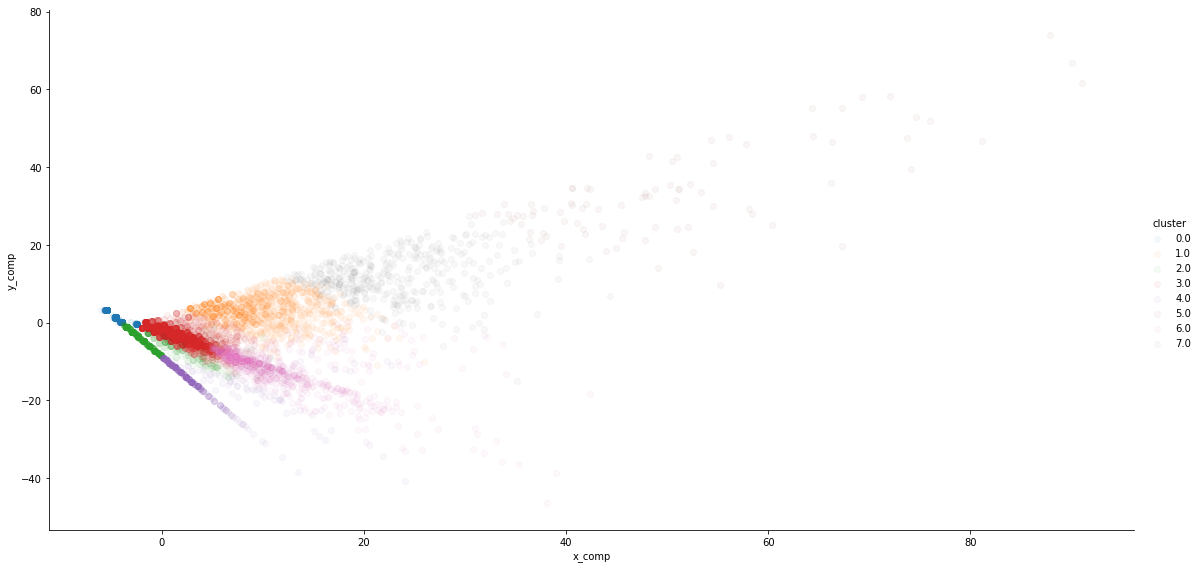

In [61]:
sns.lmplot('x_comp', 'y_comp', data=vis2d_df, hue='cluster', fit_reg=False, height=8, aspect=2, scatter_kws={'alpha': 0.05});

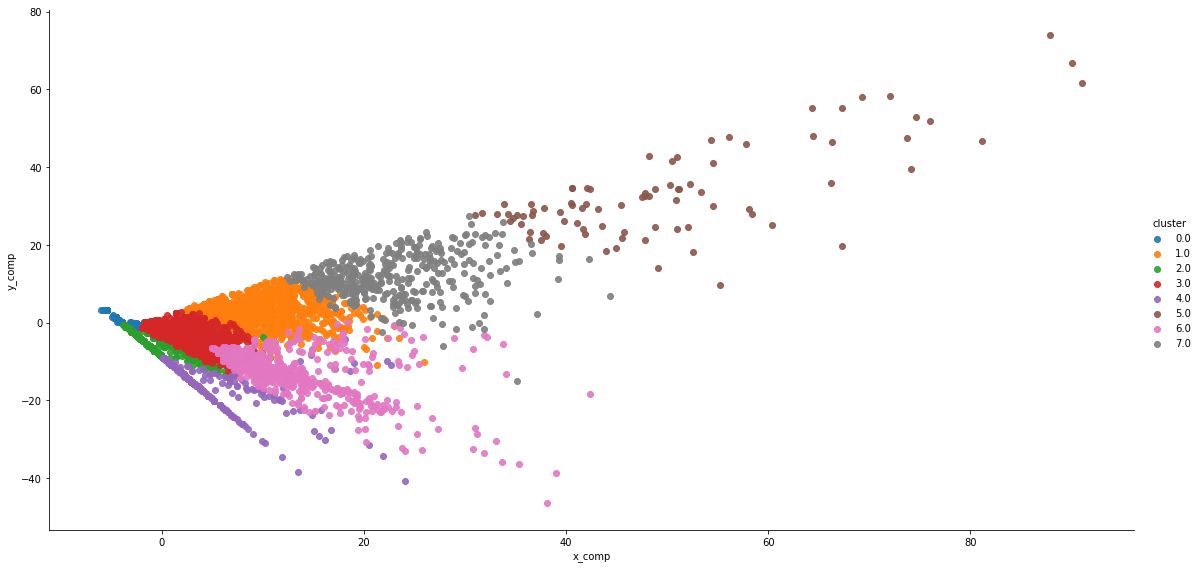

In [62]:
sns.lmplot('x_comp', 'y_comp', data=vis2d_df, hue='cluster', fit_reg=False, height=8, aspect=2, scatter_kws={'alpha': 0.9});

In [72]:
fig = go.Figure(data=[go.Scatter3d(
    x=vis3d_df['x_comp'],
    y=vis3d_df['y_comp'],
    z=vis3d_df['z_comp'],
    mode='markers',
    marker=dict(
        size=4,
        color=vis3d_df['cluster'], # set color to an array/list of desired values
        colorscale=[(0, "red"), (0.14, "yellow"), (0.29, "purple"), (0.43, "green"), (0.57, "blue"), (0.71, "black"), (0.86, "orange"), (1, "pink")],   # choose a colorscale
        opacity=0.5
    )
)])
fig.show()